In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv("dmzo_nomal.csv", usecols=[0], nrows=30000, header=None, names=["Sentence"])
df1["Label"] = 0  # Normal veriye etiket 0

df2 = pd.read_csv("xssed.csv", usecols=[0], nrows=30000, header=None, names=["Sentence"])
df2["Label"] = 1  # XSS zararlı veriye etiket 1

# Veri kümesini birleştir ve karıştır
df = pd.concat([df1, df2], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

# Metin ve etiketleri listeye çevir
texts = df["Sentence"].astype(str).tolist()
labels = df["Label"].astype(int).tolist()  # Label'ları integer'a çevir

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding index

# Padding sequences
# max_length = max(len(seq) for seq in sequences)
max_length=100
X = pad_sequences(sequences, maxlen=max_length, padding="post")
y = np.array(labels)
# print(f"df: {df}")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
controlInput = X_train[0]
vectorSize=max_length
# Word2Vec Modelini Eğit
w2v_model = Word2Vec(sentences=[text.split() for text in texts], vector_size=vectorSize, window=5, min_count=1, workers=4)

# Embedding Matrix Oluştur
embedding_matrix = np.zeros((vocab_size, vectorSize))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


Epoch 1/30
1500/1500 [==============================] - 117s 76ms/step - loss: 0.2075 - accuracy: 0.9019 - val_loss: 0.0799 - val_accuracy: 0.9837
Epoch 2/30
1500/1500 [==============================] - 112s 75ms/step - loss: 0.0776 - accuracy: 0.9843 - val_loss: 0.0757 - val_accuracy: 0.9847
Epoch 3/30
1500/1500 [==============================] - 112s 75ms/step - loss: 0.0734 - accuracy: 0.9852 - val_loss: 0.0752 - val_accuracy: 0.9849
Epoch 4/30
1500/1500 [==============================] - 112s 75ms/step - loss: 0.0705 - accuracy: 0.9856 - val_loss: 0.0745 - val_accuracy: 0.9849
Epoch 5/30
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0699 - accuracy: 0.9857 - val_loss: 0.0734 - val_accuracy: 0.9852
Epoch 6/30
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0675 - accuracy: 0.9864 - val_loss: 0.0699 - val_accuracy: 0.9860
Epoch 7/30
1500/1500 [==============================] - 111s 74ms/step - loss: 0.0684 - accuracy: 0.9859 - val_loss: 0

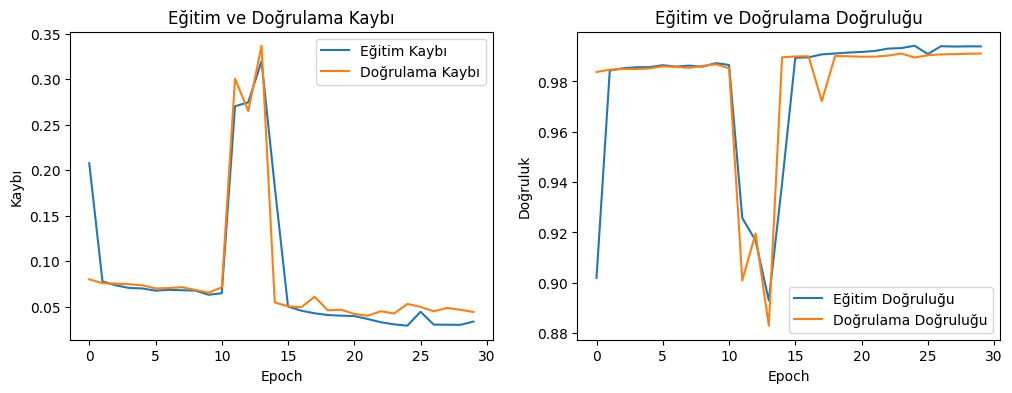

In [5]:
model = Sequential([
    Embedding(vocab_size, vectorSize, weights=[embedding_matrix], input_length=max_length, trainable=True),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(4),
    Dropout(0.2),
    Dense(4, activation='tanh'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# Train Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Eğitim ve doğrulama kayıplarını çiz
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kaybı')
plt.legend()

# Eğitim ve doğrulama doğruluklarını çiz
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()

In [ ]:
# model.save("lstm3_xss_model.h5")
reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}

def sequence_to_text(sequence, tokenizer):
    words = [reverse_word_map.get(i, '') for i in sequence if i != 0]
    return ' '.join(words)
controlInput = X_train[2]
text_equivalent = sequence_to_text(controlInput, tokenizer)
print(text_equivalent)

print("------------------")
print(X_train[2])

catid 22 3e 3cscript 3ealert 22virtual system 22 3c scrip br t 3e
------------------
[ 243    5    1    7    8 2963 1139    5    2  198    3   60    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [8]:
texts = ["goodday onmouseover=print()//"]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)  # Eğitimde kullandığın tokenizer'ı burada yeniden eğitmelisin
sequences = tokenizer.texts_to_sequences(texts)
max_length = 100  # Eğitim sırasında kullandığın max_length değerini aynı yapmalısın
X_input = pad_sequences(sequences, maxlen=max_length, padding="post")

# Modelden tahmin al
prediction = model.predict(X_input)

# Sonucu yazdır
if prediction[0][0] > 0.5:
    print(f"XSS Tespit Edildi! Güvenlik Riski: {prediction[0][0]:.4f}")
else:
    print(f"Güvenli: {prediction[0][0]:.4f}")
print(f"prediction = {prediction}")
print(df["Label"].value_counts())


1/1 [==============================] - 0s 26ms/step
XSS Tespit Edildi! Güvenlik Riski: 0.9996
prediction = [[0.9996402]]
Label
0    30000
1    30000
Name: count, dtype: int64


In [9]:
model.save("thisBEST2.h5")

# from tensorflow.keras.models import load_model
# from tensorflow.keras.optimizers import Adam

# model = load_model("lstm3_xss_model.h5")

# # model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])

# # model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

# # model.save("lstm3_xss_model.h5")

# # Optionally, evaluate the model after the training
# loss, accuracy = model.evaluate(X_test, y_test)

C:\Users\Yunus\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import torch
import tensorflow as tf
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0" 
# PyTorch CUDA information
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of your GPU
print(torch.version.cuda)  # CUDA version used by PyTorch

# print(tf.config.list_physical_devices('GPU'))
# print(tf.test.is_built_with_cuda())
# print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
# torch.cuda.get_device_name(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # Should print 'cuda'
tensor = torch.randn(3, 3).to(device)

# Check which device the tensor is on
print(tensor.device)  # Should show 'cuda:0' if it's on the GPU

True
1
NVIDIA GeForce GTX 1650 Ti
11.8
cuda
cuda:0
